# Symbolic regression

In [2]:
objective = """
function my_custom_objective(tree, dataset::Dataset{T,L}, options) where {T,L} 
    penalty_term = L(0)
    tot_features = 1:10
    tol = L(0.0000000000000001)
    
    P_pred = dataset.X[1,:]
    
    if tree.degree != 2
        penalty_term += L(10000)
    else
        left = tree.l
        if left.degree != 2
            penalty_term += L(1000)
        else
            # vs
            #println('l')
            fn = left.l
            features=[8,9] #function of only fck or delta
            remain_feat = setdiff(tot_features, features)
            should_nt = [any(n -> n.degree == 0 && n.constant == false && n.feature == f, fn) for f in remain_feat]
            should = [any(n -> n.degree == 0 && n.constant == false && n.feature == f, fn) for f in features]
            penalty_term += L(100) * (sum(should_nt)) + L(100) * (length(features) - sum(should))
            vs, flag = eval_tree_array(fn, dataset.X, options)
            if !flag
                return L(Inf)
            end
            penalty_term += any(x -> x < 0, vs) ? L(100) : L(0)
            
            
            # vt
            fn = left.r
            features=[8,9] #function of only fck or delta
            remain_feat = setdiff(tot_features, features)
            should_nt = [any(n -> n.degree == 0 && n.constant == false && n.feature == f, fn) for f in remain_feat]
            should = [any(n -> n.degree == 0 && n.constant == false && n.feature == f, fn) for f in features]
            penalty_term += L(100) * (sum(should_nt)) + L(100) * (length(features) - sum(should))
            vt, flag = eval_tree_array(fn, dataset.X, options)
            if !flag
                return L(Inf)
            end
            penalty_term += any(x -> x < 0, vt) ? L(100) : L(0)

            EIy=dataset.X[4,:] .+ vs .*dataset.X[6,:]
            EIx=dataset.X[5,:] .+ vs .*dataset.X[7,:]     # vtt = tol .+ vt .* transpose(dataset.X[:, 7])# vt * tan_theta
            EI = min.(EIy, EIx)
            dataset.X[10, :] = dataset.X[1,:] ./EI      #pa / Ncr
        end
        right = tree.r
        if right.degree != 2
            penalty_term += L(1000)
        else
            # vh
            #println('r')
            fn = right.l
            features=[10] #function of only rhe
            remain_feat = setdiff(tot_features, features)
            should_nt = [any(n -> n.degree == 0 && n.constant == false && n.feature == f, fn) for f in remain_feat]
            should = [any(n -> n.degree == 0 && n.constant == false && n.feature == f, fn) for f in features]
            penalty_term += L(100) * (sum(should_nt)) + L(100) * (length(features) - sum(should))
            vh, flag = eval_tree_array(fn, dataset.X, options)
            if !flag
                return L(Inf)
            end
            penalty_term += any(x -> x < 0, vh) ? L(100) : L(0)
            
            # vv
            fn = right.r
            features=[8,9] #function of only rve
            remain_feat = setdiff(tot_features, features)
            should_nt = [any(n -> n.degree == 0 && n.constant == false && n.feature == f, fn) for f in remain_feat]
            should = [any(n -> n.degree == 0 && n.constant == false && n.feature == f, fn) for f in features]
            penalty_term += L(100) * (sum(should_nt)) + L(100) * (length(features) - sum(should))
            vv, flag = eval_tree_array(fn, dataset.X, options)
            if !flag
                return L(Inf)
            end
            penalty_term += any(x -> x < 0, vv) ? L(100) : L(0)


            dims = size(vh)
            #println("vh: ", dims)
            dims = size(vv)
            #println("vv: ", dims)

            fff=dataset.X[2,:] .+ dataset.X[3,:] .* vv
            dims = size(fff)
            #println("fff: ", dims)
            
            P_pred = fff .*vh #vh .* transpose(dataset.X[7,:]) .+ vv   # vh * tan_theta +vv
        end
    end
    dims = size(dataset.y)
    #println("y: ", dims)
    dims = size(P_pred)
    #println("P_pred: ", dims)
    r = dataset.y ./P_pred .- 1.0
    MAPE = sum(abs.(r)) ./ length(r)
    return ( penalty_term  + MAPE )
end

my_custom_objective
"""
from pysr import PySRRegressor
import pandas as pd
import numpy as np
import numpy as np
import scipy.io as sio
import pandas as pd

mat_data = sio.loadmat('X_Y_data1.mat');X = mat_data['X_all'];Y = mat_data['Y_all']
PC = pd.DataFrame(X, columns=['B', 'H', 'Lam', 'frebar', 'fc', 'fy','d_steel', 'ro_rebar', 'tf_tw_2', 'cH', 'cB'])
PC['P_exp']=Y

B = PC['B']; H = PC['H']; lam = PC['Lam']; frebar = PC['frebar']; fc = PC['fc']; fy = PC['fy']
d_steel = PC['d_steel']; ro_rebar = PC['ro_rebar']; tf_tw_2 = PC['tf_tw_2']; cH = PC['cH']; cB = PC['cB']

A_rebar_4 = ro_rebar * B * H / 4.0; cover = 30; L = lam * B;hs2 = (H - 2.0 * cH) / 2.0;bf2 = (B - 2.0 * cB) / 2.0

A_steel_4 = (4.*A_rebar_4 * frebar + 0.85 * B * H * 0.97 * fc) * d_steel / fy / 4.0
tw2 = A_steel_4 / ((bf2 - 4.0) * tf_tw_2 + hs2)
tf = (A_steel_4 - hs2 * tw2) / (bf2 - tw2)


f_fc = 0.85;Es = 210000;Ec = 22000 * ((fc + 8.) / 10.)**0.3
Ar = ro_rebar * B * H
As = ((hs2 * 2.) * (bf2 * 2.) - (hs2 * 2. - 2. * tf) * (bf2 * 2. - 2. * tw2))
Ac = H * B - Ar - As
I_S_X = ((hs2 * 2.)**3. * (bf2 * 2.) - (hs2 * 2. - 2. * tf)**3 * (bf2 * 2. - 2. * tw2)) / 12.0
I_REBAR_X = Ar * (H - 2.0 * cover)**2. / 4.0
EI1 = (I_S_X + I_REBAR_X) * Es + (H**3. * B/12.0 - I_S_X - I_REBAR_X) * Ec * 0.6
I_S_Y = ((bf2 * 2.)**3. * tf * 2.0 + (hs2 * 2. - 2. * tf) * (2. * tw2)**3) / 12.0
I_REBAR_Y = Ar * (B - 2.0 * cover)**2. / 4.0
EI2 = (I_S_Y + I_REBAR_Y) * Es + (H * B**3./12.0 - I_S_Y - I_REBAR_Y) * Ec * 0.6
EI = np.minimum(EI1, EI2)

pc = Ac * fc * f_fc
pa = pc + As * fy + Ar * frebar

Ncr = (np.pi**2. * EI) / (L * L)
slender = (pa / Ncr)**0.5
phi = 0.5 * (1 + 0.21 * (slender - 0.2) + slender**2)
chi = np.minimum(1, 1 / (phi + (phi**2 - slender**2)**0.5))
EC4 = chi * pa/1000.0/PC['P_exp']


PC['tw2']=tw2;PC['tf']=tf;PC['delta']=(As * fy)/pa;PC['bf2']=bf2;PC['hs2']=hs2;PC['A_rebar']=A_rebar_4*4.0
X=PC[['B', 'H', 'Lam', 'frebar', 'fc', 'delta','tw2', 'tf', 'hs2', 'bf2','A_rebar']];y=PC['P_exp']/pa

PC['pa']=pa;PC['pc']=pc;PC['psr']=As * fy + Ar * frebar
PC['Iy_sr']=(I_S_Y + I_REBAR_Y) * Es* np.pi**2./ (L * L);PC['Ix_sr']=(I_S_X + I_REBAR_X) * Es* np.pi**2./ (L * L)
PC['Iy_c']=(H * B**3./12.0 - I_S_Y - I_REBAR_Y) * Ec* np.pi**2./ (L * L);PC['Ix_c']=(H**3. * B/12.0 - I_S_X - I_REBAR_X) * Ec* np.pi**2./ (L * L)
PC['fck']=PC['fc']/30.0;PC['slender']=slender**2.0
features=['pa','psr','pc','Iy_sr','Ix_sr','Iy_c','Ix_c','fck', 'delta','slender']

X=PC[features];y=PC['P_exp']

modelior11=[]
for j in range(15):
    #population_size is the equation size
    model7 = PySRRegressor(niterations=200,populations=20,population_size=50,maxsize=50,
                      nested_constraints={"^":{"^":1}},parsimony= 0.02,#adaptive_parsimony_scaling=1000,
                      constraints={"^":(-1,10)},
                      binary_operators=["+", "*","^"],#special(x,y)=x^2.0+y
                      denoise=True,loss_function=objective,model_selection ='accuracy',
                      )
    model7.fit(X,y)
    i=0
    modelior11.append(model7)
    while i <len(model7.equations_):
        print(model7.sympy(i))
        i=i+1

c:\Users\osama\anaconda3\lib\site-packages\pysr\sr.py:1230: UserWarning: Note: Using a large maxsize for the equation search will be exponentially slower and use significant memory.
  warnings.warn(
c:\Users\osama\anaconda3\lib\site-packages\pysr\sr.py:1297: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
c:\Users\osama\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\osama\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\User


Expressions evaluated per second: 3.660e+04
Head worker occupation: 4.1%
Progress: 63 / 4000 total iterations (1.575%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.000e+04  1.594e+01  y = 0.74504
3           2.001e+03  8.045e-01  y = (0.98099 + delta)
5           1.101e+03  2.987e-01  y = (slender * (slender + delta))
7           3.009e+02  6.485e-01  y = ((fck + delta) + (slender + delta))
9           2.010e+02  2.018e-01  y = ((fck + fck) * (slender + (fck * delta)))
11          1.010e+02  3.441e-01  y = (((fck * delta) + fck) ^ (slender + (fck * delta)))
13          9.998e-01  2.308e+00  y = (((delta ^ fck) * (delta ^ fck)) * (slender ^ (delta ^ fck...
                                  )))
15          9.994e-01  1.683e-04  y = (((fck ^ delta) * (fck * delta)) ^ ((1.3674 + slender) + (...
                                  delta ^ fck)))
17          9.988e-01  

c:\Users\osama\anaconda3\lib\site-packages\pysr\sr.py:1230: UserWarning: Note: Using a large maxsize for the equation search will be exponentially slower and use significant memory.
  warnings.warn(
c:\Users\osama\anaconda3\lib\site-packages\pysr\sr.py:1297: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
c:\Users\osama\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\osama\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\User


Expressions evaluated per second: 4.000e+04
Head worker occupation: 5.6%
Progress: 71 / 4000 total iterations (1.775%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.000e+04  1.594e+01  y = fck
3           2.001e+03  8.045e-01  y = (pa * Iy_c)
5           1.101e+03  2.987e-01  y = (delta ^ (slender ^ delta))
7           3.010e+02  6.484e-01  y = ((fck ^ fck) ^ (slender + delta))
9           2.009e+02  2.022e-01  y = ((fck * delta) ^ (slender * (delta ^ fck)))
11          1.010e+02  3.438e-01  y = (((delta ^ fck) ^ (delta + fck)) * (slender * delta))
13          9.990e-01  2.308e+00  y = (((delta ^ fck) + (delta * fck)) * (slender * (delta ^ fck...
                                  )))
15          9.920e-01  3.550e-03  y = (((delta ^ fck) + (delta ^ fck)) ^ ((slender ^ -1.5206) * ...
                                  (delta ^ fck)))
17          9.061e-01  4.526e-02

c:\Users\osama\anaconda3\lib\site-packages\pysr\sr.py:1230: UserWarning: Note: Using a large maxsize for the equation search will be exponentially slower and use significant memory.
  warnings.warn(
c:\Users\osama\anaconda3\lib\site-packages\pysr\sr.py:1297: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
c:\Users\osama\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\osama\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\User


Expressions evaluated per second: 3.580e+04
Head worker occupation: 5.1%
Progress: 61 / 4000 total iterations (1.525%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.000e+04  1.594e+01  y = 0.022332
3           2.001e+03  8.045e-01  y = (delta ^ -0.28713)
5           1.101e+03  2.987e-01  y = (fck ^ (slender * delta))
7           3.010e+02  6.485e-01  y = ((fck ^ fck) * (slender * fck))
9           2.010e+02  2.019e-01  y = (((fck * delta) + delta) ^ (slender + delta))
11          1.010e+02  3.441e-01  y = (((fck + delta) + delta) ^ (slender + (delta * fck)))
13          9.998e-01  2.308e+00  y = (((delta ^ fck) * (fck + delta)) * (slender + (delta ^ fck...
                                  )))
15          9.995e-01  1.137e-04  y = (((fck ^ delta) * ((fck + delta) ^ 0.42682)) ^ (slender + ...
                                  (delta * fck)))
17          9.990e-01 

c:\Users\osama\anaconda3\lib\site-packages\pysr\sr.py:1230: UserWarning: Note: Using a large maxsize for the equation search will be exponentially slower and use significant memory.
  warnings.warn(
c:\Users\osama\anaconda3\lib\site-packages\pysr\sr.py:1297: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
c:\Users\osama\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\osama\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\User


Expressions evaluated per second: 3.670e+04
Head worker occupation: 6.6%
Progress: 63 / 4000 total iterations (1.575%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.000e+04  1.594e+01  y = fck
3           2.001e+03  8.045e-01  y = (fck + fck)
5           1.101e+03  2.987e-01  y = (delta * (slender ^ delta))
7           3.010e+02  6.484e-01  y = ((delta + fck) ^ (slender ^ delta))
9           2.009e+02  2.020e-01  y = (((delta ^ fck) * fck) + (slender + delta))
11          1.010e+02  3.440e-01  y = (((delta + fck) * fck) + (slender + (delta * fck)))
13          1.009e+02  4.453e-04  y = ((delta ^ (delta * (fck + -0.31981))) ^ (slender * (delta ...
                                  + fck)))
15          9.995e-01  2.307e+00  y = (((delta + fck) + (delta * fck)) + (slender ^ (delta + (0....
                                  10421 * fck))))
17          9.987e-01  4.12

In [1]:
objective = """
function my_custom_objective(tree, dataset::Dataset{T,L}, options) where {T,L} 
    penalty_term = L(0)
    tot_features = 1:10
    tol = L(0.0000000000000001)
    
    P_pred = dataset.X[1,:]
    
    if tree.degree != 2
        penalty_term += L(10000)
    else
        left = tree.l
        if left.degree != 2
            penalty_term += L(1000)
        else
            # vs
            #println('l')
            fn = left.l
            features=[8,9] #function of only fck or delta
            remain_feat = setdiff(tot_features, features)
            should_nt = [any(n -> n.degree == 0 && n.constant == false && n.feature == f, fn) for f in remain_feat]
            should = [any(n -> n.degree == 0 && n.constant == false && n.feature == f, fn) for f in features]
            penalty_term += L(100) * (sum(should_nt)) + L(100) * (length(features) - sum(should))
            vs, flag = eval_tree_array(fn, dataset.X, options)
            if !flag
                return L(Inf)
            end
            penalty_term += any(x -> x < 0, vs) ? L(100) : L(0)
            
            
            # vt
            fn = left.r
            features=[8,9] #function of only fck or delta
            remain_feat = setdiff(tot_features, features)
            should_nt = [any(n -> n.degree == 0 && n.constant == false && n.feature == f, fn) for f in remain_feat]
            should = [any(n -> n.degree == 0 && n.constant == false && n.feature == f, fn) for f in features]
            penalty_term += L(100) * (sum(should_nt)) + L(100) * (length(features) - sum(should))
            vt, flag = eval_tree_array(fn, dataset.X, options)
            if !flag
                return L(Inf)
            end
            penalty_term += any(x -> x < 0, vt) ? L(100) : L(0)

            EIy=dataset.X[4,:] .+ vs .*dataset.X[6,:]
            EIx=dataset.X[5,:] .+ vs .*dataset.X[7,:]     # vtt = tol .+ vt .* transpose(dataset.X[:, 7])# vt * tan_theta
            EI = min.(EIy, EIx)
            dataset.X[10, :] = dataset.X[1,:] ./EI      #pa / Ncr
        end
        right = tree.r
        if right.degree != 2
            penalty_term += L(1000)
        else
            # vh
            #println('r')
            fn = right.l
            features=[10] #function of only rhe
            remain_feat = setdiff(tot_features, features)
            should_nt = [any(n -> n.degree == 0 && n.constant == false && n.feature == f, fn) for f in remain_feat]
            should = [any(n -> n.degree == 0 && n.constant == false && n.feature == f, fn) for f in features]
            penalty_term += L(100) * (sum(should_nt)) + L(100) * (length(features) - sum(should))
            vh, flag = eval_tree_array(fn, dataset.X, options)
            if !flag
                return L(Inf)
            end
            penalty_term += any(x -> x < 0, vh) ? L(100) : L(0)
            
            # vv
            fn = right.r
            features=[8,9] #function of only rve
            remain_feat = setdiff(tot_features, features)
            should_nt = [any(n -> n.degree == 0 && n.constant == false && n.feature == f, fn) for f in remain_feat]
            should = [any(n -> n.degree == 0 && n.constant == false && n.feature == f, fn) for f in features]
            penalty_term += L(100) * (sum(should_nt)) + L(100) * (length(features) - sum(should))
            vv, flag = eval_tree_array(fn, dataset.X, options)
            if !flag
                return L(Inf)
            end
            penalty_term += any(x -> x < 0, vv) ? L(100) : L(0)


            dims = size(vh)
            #println("vh: ", dims)
            dims = size(vv)
            #println("vv: ", dims)

            fff=dataset.X[2,:] .+ dataset.X[3,:] .* vv
            dims = size(fff)
            #println("fff: ", dims)
            
            P_pred = fff .*vh #vh .* transpose(dataset.X[7,:]) .+ vv   # vh * tan_theta +vv
        end
    end
    dims = size(dataset.y)
    #println("y: ", dims)
    dims = size(P_pred)
    #println("P_pred: ", dims)
    r = dataset.y ./P_pred .- 1.0
    MAPE = sum(abs.(r)) ./ length(r)
    return ( penalty_term  + MAPE )
end

my_custom_objective
"""
from pysr import PySRRegressor
import pandas as pd
import numpy as np
import numpy as np
import scipy.io as sio
import pandas as pd

mat_data = sio.loadmat('X_Y_data1.mat');X = mat_data['X_all'];Y = mat_data['Y_all']
PC = pd.DataFrame(X, columns=['B', 'H', 'Lam', 'frebar', 'fc', 'fy','d_steel', 'ro_rebar', 'tf_tw_2', 'cH', 'cB'])
PC['P_exp']=Y

B = PC['B']; H = PC['H']; lam = PC['Lam']; frebar = PC['frebar']; fc = PC['fc']; fy = PC['fy']
d_steel = PC['d_steel']; ro_rebar = PC['ro_rebar']; tf_tw_2 = PC['tf_tw_2']; cH = PC['cH']; cB = PC['cB']

A_rebar_4 = ro_rebar * B * H / 4.0; cover = 30; L = lam * B;hs2 = (H - 2.0 * cH) / 2.0;bf2 = (B - 2.0 * cB) / 2.0

A_steel_4 = (4.*A_rebar_4 * frebar + 0.85 * B * H * 0.97 * fc) * d_steel / fy / 4.0
tw2 = A_steel_4 / ((bf2 - 4.0) * tf_tw_2 + hs2)
tf = (A_steel_4 - hs2 * tw2) / (bf2 - tw2)


f_fc = 0.85;Es = 210000;Ec = 22000 * ((fc + 8.) / 10.)**0.3
Ar = ro_rebar * B * H
As = ((hs2 * 2.) * (bf2 * 2.) - (hs2 * 2. - 2. * tf) * (bf2 * 2. - 2. * tw2))
Ac = H * B - Ar - As
I_S_X = ((hs2 * 2.)**3. * (bf2 * 2.) - (hs2 * 2. - 2. * tf)**3 * (bf2 * 2. - 2. * tw2)) / 12.0
I_REBAR_X = Ar * (H - 2.0 * cover)**2. / 4.0
EI1 = (I_S_X + I_REBAR_X) * Es + (H**3. * B/12.0 - I_S_X - I_REBAR_X) * Ec * 0.6
I_S_Y = ((bf2 * 2.)**3. * tf * 2.0 + (hs2 * 2. - 2. * tf) * (2. * tw2)**3) / 12.0
I_REBAR_Y = Ar * (B - 2.0 * cover)**2. / 4.0
EI2 = (I_S_Y + I_REBAR_Y) * Es + (H * B**3./12.0 - I_S_Y - I_REBAR_Y) * Ec * 0.6
EI = np.minimum(EI1, EI2)

pc = Ac * fc * f_fc
pa = pc + As * fy + Ar * frebar

Ncr = (np.pi**2. * EI) / (L * L)
slender = (pa / Ncr)**0.5
phi = 0.5 * (1 + 0.21 * (slender - 0.2) + slender**2)
chi = np.minimum(1, 1 / (phi + (phi**2 - slender**2)**0.5))
EC4 = chi * pa/1000.0/PC['P_exp']


PC['tw2']=tw2;PC['tf']=tf;PC['delta']=(As * fy)/pa;PC['bf2']=bf2;PC['hs2']=hs2;PC['A_rebar']=A_rebar_4*4.0
X=PC[['B', 'H', 'Lam', 'frebar', 'fc', 'delta','tw2', 'tf', 'hs2', 'bf2','A_rebar']];y=PC['P_exp']/pa

PC['pa']=pa;PC['pc']=pc;PC['psr']=As * fy + Ar * frebar
PC['Iy_sr']=(I_S_Y + I_REBAR_Y) * Es* np.pi**2./ (L * L);PC['Ix_sr']=(I_S_X + I_REBAR_X) * Es* np.pi**2./ (L * L)
PC['Iy_c']=(H * B**3./12.0 - I_S_Y - I_REBAR_Y) * Ec* np.pi**2./ (L * L);PC['Ix_c']=(H**3. * B/12.0 - I_S_X - I_REBAR_X) * Ec* np.pi**2./ (L * L)
PC['fck']=PC['fc']/30.0;PC['slender']=slender**2.0
features=['pa','psr','pc','Iy_sr','Ix_sr','Iy_c','Ix_c','fck', 'delta','slender']

X=PC[features];y=PC['P_exp']

modelior11=[]
for j in range(15):
    #population_size is the equation size
    model7 = PySRRegressor(niterations=200,populations=20,population_size=50,maxsize=50,
                      nested_constraints={"^":{"^":1}},parsimony= 0.02,#adaptive_parsimony_scaling=1000,
                      constraints={"^":(-1,10)},
                      binary_operators=["+", "*","^"],#special(x,y)=x^2.0+y
                      denoise=True,loss_function=objective,model_selection ='accuracy',
                      )
    model7.fit(X,y)
    i=0
    modelior11.append(model7)
    while i <len(model7.equations_):
        print(model7.sympy(i))
        i=i+1

Detected Jupyter notebook. Loading juliacall extension. Set `PYSR_AUTOLOAD_EXTENSIONS=no` to disable.


c:\Users\osama\anaconda3\lib\site-packages\pysr\sr.py:1230: UserWarning: Note: Using a large maxsize for the equation search will be exponentially slower and use significant memory.
  warnings.warn(
c:\Users\osama\anaconda3\lib\site-packages\pysr\sr.py:1297: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
c:\Users\osama\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\osama\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\User

Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 3.060e+04
Head worker occupation: 4.4%
Progress: 60 / 4000 total iterations (1.500%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.000e+04  1.594e+01  y = 1.4949
3           2.001e+03  8.045e-01  y = (slender + fck)
5           1.101e+03  2.987e-01  y = (pa * (slender * delta))
7           3.010e+02  6.484e-01  y = ((fck * fck) + (slender * delta))
9           2.010e+02  2.019e-01  y = ((fck + (fck + delta)) ^ (slender ^ fck))
11          1.010e+02  3.441e-01  y = ((fck * (delta * fck)) + (slender * (delta * fck)))
13          9.961e-01  2.310e+00  y = (((fck ^ delta) * (fck + delta)) * (slender + (fck * delta...
                                  )))
23          9.910e-01  5.050e-04  y = (((((fck + delta) + (fck + delta)) ^ (slender + (fck + del...
                                  ta))) + (fck + delta)) ^ (slender + (fck * delta

# Data Distribution

In [4]:
from skopt import gp_minimize
from skopt import forest_minimize # Bayesian Optimization with RF as surrogate
from skopt import gbrt_minimize # Bayesian Optimization with GBM as surrogate
from skopt import Optimizer # for the optimization
from joblib import Parallel, delayed # for the parallelization
from skopt import dummy_minimize # for the randomized search
from skopt.plots import plot_convergence
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
cv = KFold(n_splits=5, shuffle=True, random_state=1)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import math
from math import pi

In [5]:
import numpy as np
import scipy.io as sio
import pandas as pd

mat_data = sio.loadmat('X_Y_data1.mat');X = mat_data['X_all'];Y = mat_data['Y_all']
PC = pd.DataFrame(X, columns=['B', 'H', 'Lam', 'frebar', 'fc', 'fy','d_steel', 'ro_rebar', 'tf_tw_2', 'cH', 'cB'])
PC['P_exp']=Y

B = PC['B']; H = PC['H']; lam = PC['Lam']; frebar = PC['frebar']; fc = PC['fc']; fy = PC['fy']
d_steel = PC['d_steel']; ro_rebar = PC['ro_rebar']; tf_tw_2 = PC['tf_tw_2']; cH = PC['cH']; cB = PC['cB']

A_rebar_4 = ro_rebar * B * H / 4.0; cover = 30; L = lam * B;hs2 = (H - 2.0 * cH) / 2.0;bf2 = (B - 2.0 * cB) / 2.0

A_steel_4 = (4.*A_rebar_4 * frebar + 0.85 * B * H * 0.97 * fc) * d_steel / fy / 4.0
tw2 = A_steel_4 / ((bf2 - 4.0) * tf_tw_2 + hs2)
tf = (A_steel_4 - hs2 * tw2) / (bf2 - tw2)


f_fc = 0.85;Es = 210000;Ec = 22000 * ((fc + 8.) / 10.)**0.3
Ar = ro_rebar * B * H
As = ((hs2 * 2.) * (bf2 * 2.) - (hs2 * 2. - 2. * tf) * (bf2 * 2. - 2. * tw2))
Ac = H * B - Ar - As
I_S_X = ((hs2 * 2.)**3. * (bf2 * 2.) - (hs2 * 2. - 2. * tf)**3 * (bf2 * 2. - 2. * tw2)) / 12.0
I_REBAR_X = Ar * (H - 2.0 * cover)**2. / 4.0
EI1 = (I_S_X + I_REBAR_X) * Es + (H**3. * B/12.0 - I_S_X - I_REBAR_X) * Ec * 0.6
I_S_Y = ((bf2 * 2.)**3. * tf * 2.0 + (hs2 * 2. - 2. * tf) * (2. * tw2)**3) / 12.0
I_REBAR_Y = Ar * (B - 2.0 * cover)**2. / 4.0
EI2 = (I_S_Y + I_REBAR_Y) * Es + (H * B**3./12.0 - I_S_Y - I_REBAR_Y) * Ec * 0.6
EI = np.minimum(EI1, EI2)

pc = Ac * fc * f_fc
pa = pc + As * fy + Ar * frebar

Ncr = (np.pi**2. * EI) / (L * L)
slender = (pa / Ncr)**0.5
phi = 0.5 * (1 + 0.21 * (slender - 0.2) + slender**2)
chi = np.minimum(1, 1 / (phi + (phi**2 - slender**2)**0.5))
EC4 = chi * pa/1000.0/PC['P_exp']


PC['tw2']=tw2;PC['tf']=tf;PC['delta']=(As * fy)/pa;PC['bf2']=bf2;PC['hs2']=hs2;PC['A_rebar']=A_rebar_4*4.0
X=PC[['B', 'H', 'Lam', 'frebar', 'fc', 'delta','tw2', 'tf', 'hs2', 'bf2','A_rebar']];y=PC['P_exp']/pa

In [6]:
from scipy.stats import skew, kurtosis
from tabulate import tabulate
# Create a list to store the statistical properties for each feature
PC['slender']=slender
PC['tw']=2.0*PC['tw2'];PC['hs']=2.0*PC['hs2'];PC['bf']=2.0*PC['bf2'];PC['rho_l']=PC['A_rebar']/PC['B']/PC['H'];PC['fy']=fy;PC['P_PcS']=y;PC['P_PcS1']=y*1000.0
features = ['B', 'H', 'Lam', 'frebar', 'fc','fy', 'delta','tw', 'tf', 'hs', 'bf','rho_l','slender','P_exp', 'P_PcS1']
X1=PC[['B', 'H', 'Lam', 'frebar', 'fc','fy', 'delta','tw', 'tf', 'hs', 'bf','rho_l','slender','P_exp', 'P_PcS1']]
correlation_matrix = X1.corr()
print(correlation_matrix)
data_stats = pd.DataFrame()

# Calculate statistical properties for each feature
data_stats['Min'] = PC[features].min()
data_stats['Max'] = PC[features].max()
data_stats['Mean'] = PC[features].mean()
data_stats['Std'] = PC[features].std()
data_stats['Skewness'] = PC[features].apply(skew)
data_stats['Kurtosis'] = PC[features].apply(kurtosis)

# Display the statistical properties
print(data_stats)


                B         H       Lam    frebar        fc        fy     delta  \
B        1.000000 -0.179293  0.021350 -0.123140 -0.014676  0.046444 -0.067314   
H       -0.179293  1.000000  0.129340  0.012224 -0.150704 -0.046768  0.028541   
Lam      0.021350  0.129340  1.000000  0.008185  0.013010 -0.070255  0.059849   
frebar  -0.123140  0.012224  0.008185  1.000000 -0.054655  0.017882  0.007647   
fc      -0.014676 -0.150704  0.013010 -0.054655  1.000000 -0.016875 -0.002369   
fy       0.046444 -0.046768 -0.070255  0.017882 -0.016875  1.000000  0.026657   
delta   -0.067314  0.028541  0.059849  0.007647 -0.002369  0.026657  1.000000   
tw      -0.206384  0.231891  0.083053  0.058959  0.378672 -0.378144  0.629205   
tf      -0.211570  0.223613  0.077990  0.069860  0.395281 -0.388815  0.614811   
hs      -0.170918  0.959447  0.133687  0.010056 -0.135210 -0.045261  0.031508   
bf       0.917873 -0.164387  0.035567 -0.114798 -0.047860  0.063374 -0.055435   
rho_l   -0.075664 -0.029340 

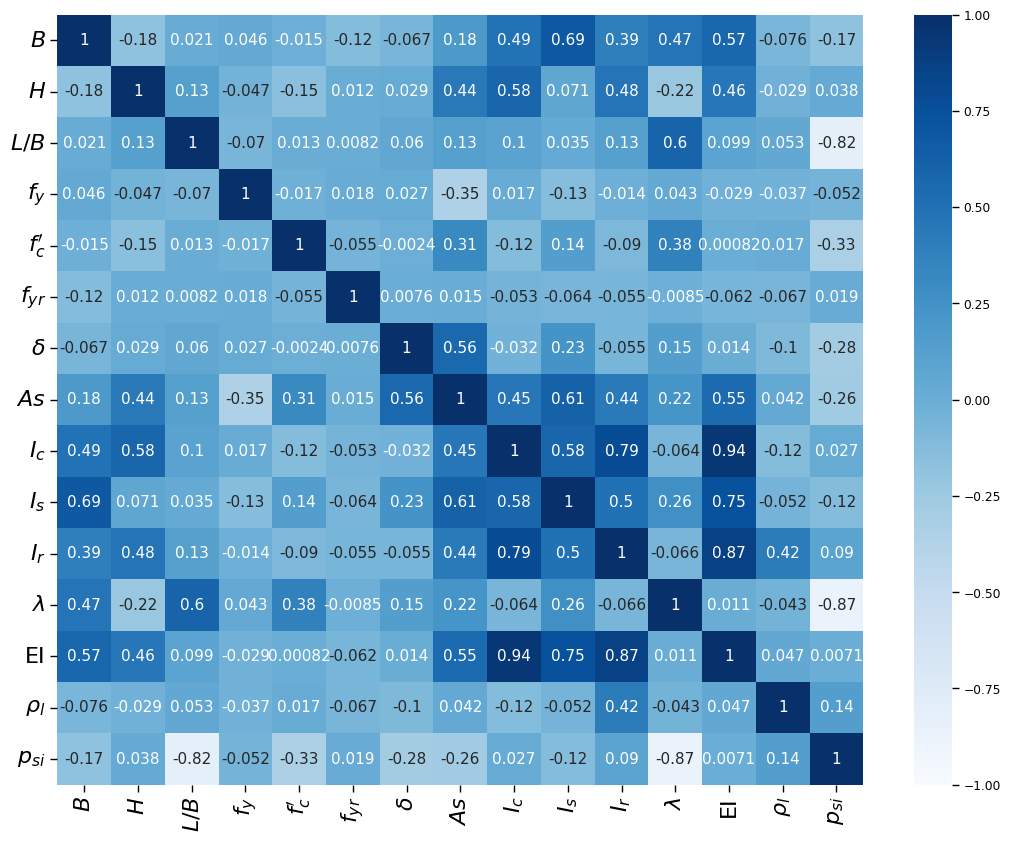

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
PC['As']=As; PC['Ic']=np.minimum((H**3. * B/12.0 - I_S_X - I_REBAR_X),(H * B**3./12.0 - I_S_Y - I_REBAR_Y));PC['Is']=np.minimum(I_S_X,I_S_Y); PC['I_REBAR_X']=np.minimum(I_REBAR_X,I_REBAR_Y)
PC['EI']=EI;
X1=PC[['B', 'H', 'Lam', 'fy', 'fc','frebar', 'delta','As','Ic','Is','I_REBAR_X','slender','EI','rho_l', 'P_PcS']]
column_labels = ['$B$', '$H$', '$L/B$', '$f_y$', '$f^\\prime_c$','$f_{yr}$','$\\delta$','$As$','$I_c$', '$I_s$','$I_r$','$\\lambda$','EI','$\\rho_l$','$p_{si}$']#\\tilde{p}

# Calculate Pearson's correlation coefficient between features (X1)
correlation_matrix = X1.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(13, 10),)
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", vmin=-1, vmax=1, center=0)

sns.set_context("paper", rc={"font.size": 11, "axes.titlesize": 12, "axes.labelsize": 12})
plt.xticks(fontsize=16);plt.yticks(fontsize=16)
plt.xticks(ticks=np.arange(len(column_labels)) + 0.5, labels=column_labels)
plt.yticks(ticks=np.arange(len(column_labels)) + 0.5, labels=column_labels)
plt.savefig("correlation_CFS.png")

# Show the colorbar as a side bar

# Display the plot
plt.show()


c:\Users\osama\anaconda3\lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


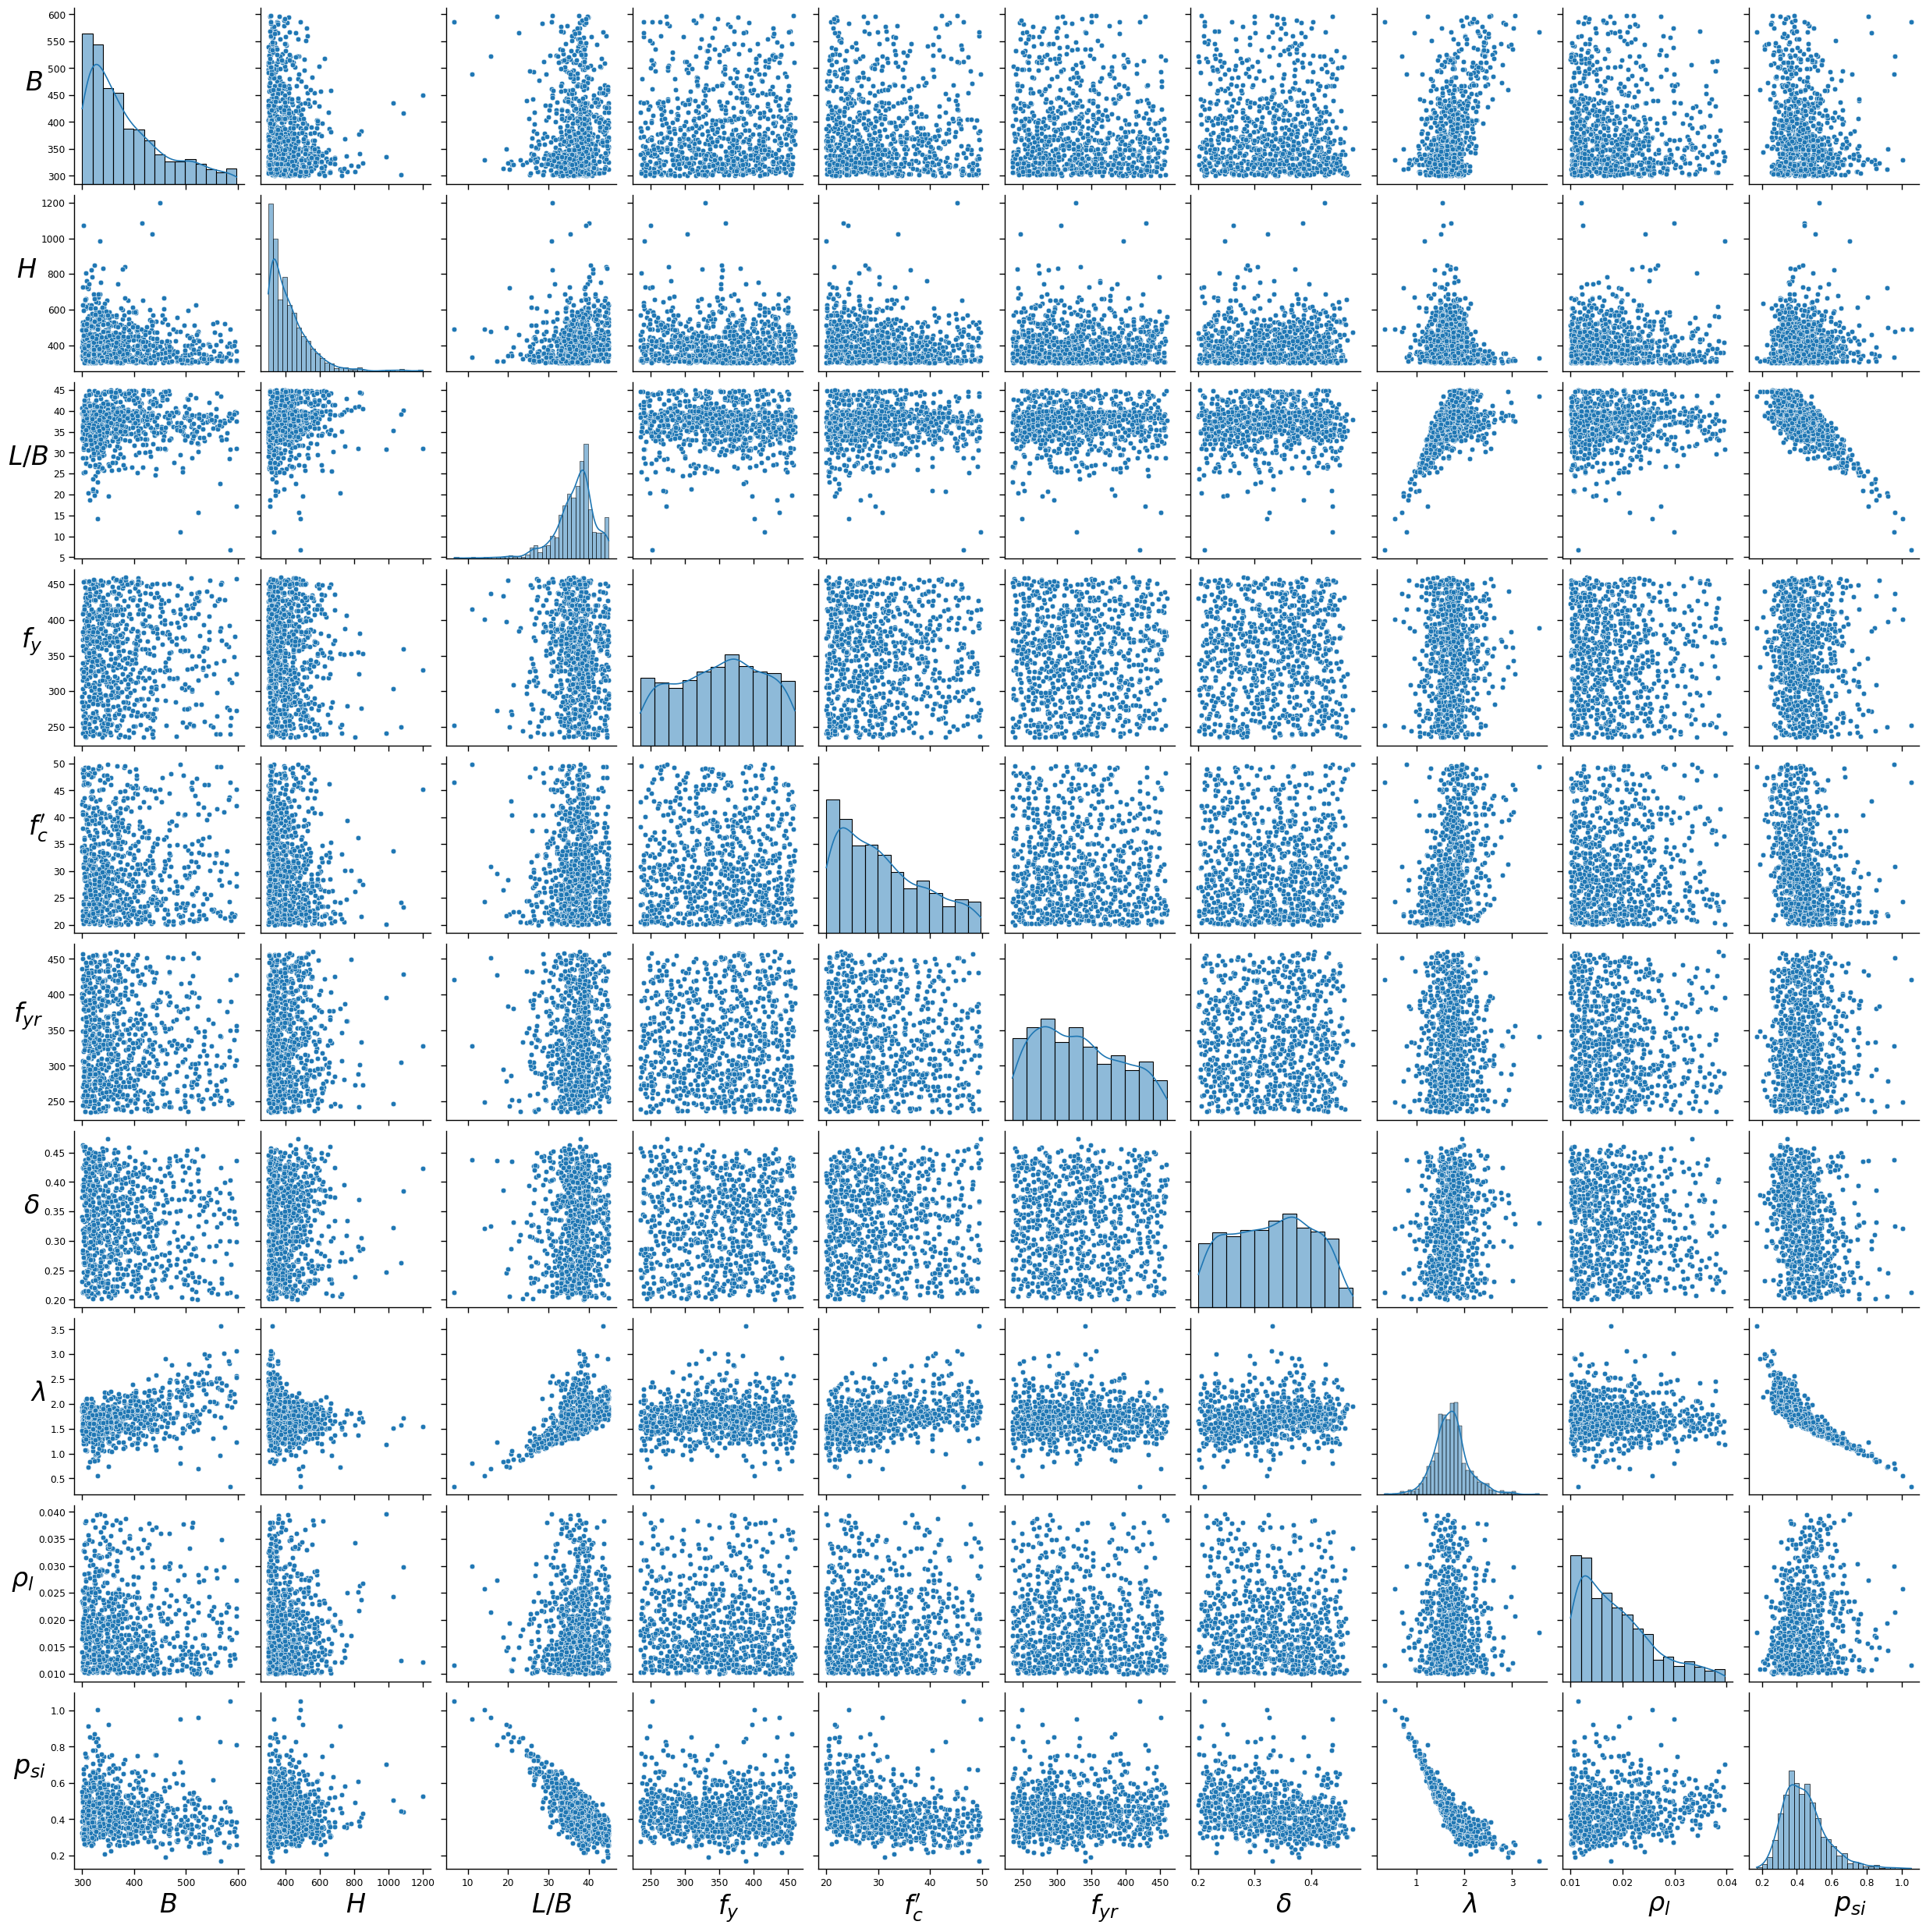

In [9]:
PC['XO']=1000.0*PC['P_PcS']
X1=PC[['B', 'H', 'Lam', 'fy', 'fc','frebar', 'delta','slender','rho_l', 'XO']]
x_vars = ['B', 'H', 'Lam', 'fy', 'fc','frebar', 'delta','slender','rho_l', 'XO']
aa=['$B$', '$H$', '$L/B$', '$f_y$', '$f^\\prime_c$','$f_{yr}$','$\\delta$','$\\lambda$','$\\rho_l$','$p_{si}$']
pairplot = sns.pairplot(X1, size=2.5, diag_kind='hist', diag_kws={'kde': True}, x_vars=x_vars)
i=0;j=0;font_size=24
for ax in pairplot.axes.flatten():
    ax.set_xlabel(aa[i],fontsize=font_size)
    ax.set_ylabel(aa[j],fontsize=font_size, rotation = 0)
    i=i+1
    if i==len(aa):
        i=0;j=j+1
    if j==len(aa):j=0
    ax.yaxis.get_label().set_horizontalalignment('right')
    ax.xaxis.get_label().set_horizontalalignment('left')
plt.savefig("correlation1_CFS.png")


# Machine Learning tunning and training

In [78]:
import numpy as np
import scipy.io as sio
import pandas as pd

mat_data = sio.loadmat('X_Y_data1.mat');X = mat_data['X_all'];Y = mat_data['Y_all']
PC = pd.DataFrame(X, columns=['B', 'H', 'Lam', 'frebar', 'fc', 'fy','d_steel', 'ro_rebar', 'tf_tw_2', 'cH', 'cB'])
PC['P_exp']=Y

B = PC['B']; H = PC['H']; lam = PC['Lam']; frebar = PC['frebar']; fc = PC['fc']; fy = PC['fy']
d_steel = PC['d_steel']; ro_rebar = PC['ro_rebar']; tf_tw_2 = PC['tf_tw_2']; cH = PC['cH']; cB = PC['cB']

A_rebar_4 = ro_rebar * B * H / 4.0; cover = 30; L = lam * B;hs2 = (H - 2.0 * cH) / 2.0;bf2 = (B - 2.0 * cB) / 2.0

A_steel_4 = (4.*A_rebar_4 * frebar + 0.85 * B * H * 0.97 * fc) * d_steel / fy / 4.0
tw2 = A_steel_4 / ((bf2 - 4.0) * tf_tw_2 + hs2)
tf = (A_steel_4 - hs2 * tw2) / (bf2 - tw2)


f_fc = 0.85;Es = 210000;Ec = 22000 * ((fc + 8.) / 10.)**0.3
Ar = ro_rebar * B * H
As = ((hs2 * 2.) * (bf2 * 2.) - (hs2 * 2. - 2. * tf) * (bf2 * 2. - 2. * tw2))
Ac = H * B - Ar - As
I_S_X = ((hs2 * 2.)**3. * (bf2 * 2.) - (hs2 * 2. - 2. * tf)**3 * (bf2 * 2. - 2. * tw2)) / 12.0
I_REBAR_X = Ar * (H - 2.0 * cover)**2. / 4.0
EI1 = (I_S_X + I_REBAR_X) * Es + (H**3. * B/12.0 - I_S_X - I_REBAR_X) * Ec * 0.6
I_S_Y = ((bf2 * 2.)**3. * tf * 2.0 + (hs2 * 2. - 2. * tf) * (2. * tw2)**3) / 12.0
I_REBAR_Y = Ar * (B - 2.0 * cover)**2. / 4.0
EI2 = (I_S_Y + I_REBAR_Y) * Es + (H * B**3./12.0 - I_S_Y - I_REBAR_Y) * Ec * 0.6
EI = np.minimum(EI1, EI2)

pc = Ac * fc * f_fc
pa = pc + As * fy + Ar * frebar

Ncr = (np.pi**2. * EI) / (L * L)
slender = (pa / Ncr)**0.5
phi = 0.5 * (1 + 0.21 * (slender - 0.2) + slender**2)
chi = np.minimum(1, 1 / (phi + (phi**2 - slender**2)**0.5))
EC4 = chi * pa/1000.0/PC['P_exp']


PC['tw2']=tw2;PC['tf']=tf;PC['delta']=(As * fy)/pa;PC['bf2']=bf2;PC['hs2']=hs2;PC['A_rebar']=A_rebar_4*4.0
X=PC[['B', 'H', 'Lam', 'frebar', 'fc', 'delta','tw2', 'tf', 'hs2', 'bf2','A_rebar']];y=PC['P_exp']/pa

In [79]:
OUT_RANGE=(1,2)#important (better than (-1,1)) as I minimize the neg_mean_absolute_percentage_error
X,y = np.array(X.values),np.array(y.values);scaler = MinMaxScaler(feature_range=(-1, 1));scaler_out = MinMaxScaler(feature_range=OUT_RANGE)
X_normalized=scaler.fit_transform(X);y_normalized=scaler_out.fit_transform(y.reshape(-1,1))
X_tot=X_normalized;y_tot=y_normalized
X_train, X_test, y_train, y_test = train_test_split(X_tot, y_tot, test_size=0.2, random_state=42)

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import optuna
import xgboost as xgb

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        "gamma": trial.suggest_float("gamma",0.01, 100, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 50),
        #"num_leaves": trial.suggest_int("num_leaves", 10, 31),
        "boosting_type": trial.suggest_categorical("booster", ['gbtree', 'dart']),#, 'rf'
    }
    model = xgb.XGBRegressor(**params)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-09-11 01:13:58,178] A new study created in memory with name: no-name-9720afbb-04b9-4f4d-9111-4fb4c1df8d41
[I 2024-09-11 01:14:04,693] Trial 7 finished with value: 0.07961153108969787 and parameters: {'n_estimators': 1618, 'learning_rate': 0.002959751236166473, 'gamma': 33.03599173074321, 'max_depth': 2, 'booster': 'gbtree'}. Best is trial 7 with value: 0.07961153108969787.
[I 2024-09-11 01:14:10,812] Trial 6 finished with value: 0.08643220844645907 and parameters: {'n_estimators': 715, 'learning_rate': 0.002777669048971943, 'gamma': 0.555274526227303, 'max_depth': 23, 'booster': 'gbtree'}. Best is trial 7 with value: 0.07961153108969787.
[I 2024-09-11 01:14:10,979] Trial 8 finished with value: 0.07398200103366694 and parameters: {'n_estimators': 976, 'learning_rate': 0.002283553324598728, 'gamma': 0.6777055244954818, 'max_depth': 5, 'booster': 'dart'}. Best is trial 8 with value: 0.07398200103366694.
[I 2024-09-11 01:14:12,488] Trial 15 finished with value: 0.06463115196119744 

In [67]:
#Best hyperparameters: {'n_estimators': 1155, 'learning_rate': 0.07587678272636933, 'gamma': 0.010906034918865362, 'max_depth': 46, 'booster': 'gbtree'}. Best is trial 53 with value: 0.026955642244050605.
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
aa=xgb.XGBRegressor(random_state=1000,n_estimators=1155, max_depth=46, learning_rate=0.07587678272636933, booster='gbtree', gamma=0.010906034918865362)
#value = np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1
aa.fit(X_train,y_train)
rmse = mean_absolute_percentage_error(y_test, aa.predict(X_test))
print(rmse)

#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)


df = pd.DataFrame(data2)
df.columns=['B', 'H', 'Lam', 'frebar', 'fc', 'delta','tw2', 'tf', 'hs2', 'bf2','A_rebar','P_exp','P_pred'];PC=df

f_fc = 0.85
Ar = PC['A_rebar'];tw2=PC['tw2'];tf=PC['tf'];bf2=PC['bf2'];hs2=PC['hs2']
As = ((hs2 * 2.) * (bf2 * 2.) - (hs2 * 2. - 2. * tf) * (bf2 * 2. - 2. * tw2))
Ac = H * B - Ar - As

pc = Ac * fc * f_fc
pa = (pc + Ar * frebar)/(1.0-PC['delta'])

PC['P_exp']=PC['P_exp']*pa
PC['P_pred']=PC['P_pred']*pa
filename = 'XGB_CFS.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

0.026364395285176017
Data exported to XGB_CFS.xlsx


In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import optuna
from lightgbm.sklearn import LGBMRegressor

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        #"gamma": trial.suggest_float("gamma",0.01, 100, log=True),
        "max_depth": trial.suggest_int("max_depth", 16, 50),
        "num_leaves": trial.suggest_int("num_leaves", 10, 31),
        "boosting_type": trial.suggest_categorical("boosting_type", ['gbdt', 'dart']),#, 'rf'
    }
    model = LGBMRegressor(**params)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-09-11 01:46:49,726] A new study created in memory with name: no-name-91a2a0b0-ae1c-45e4-8ced-a23ddae3ec50
[I 2024-09-11 01:47:17,347] Trial 7 finished with value: 0.02939566669061234 and parameters: {'n_estimators': 1387, 'learning_rate': 0.03852991118615201, 'max_depth': 49, 'num_leaves': 14, 'boosting_type': 'dart'}. Best is trial 7 with value: 0.02939566669061234.
[I 2024-09-11 01:47:30,263] Trial 2 finished with value: 0.03509072509012288 and parameters: {'n_estimators': 1171, 'learning_rate': 0.04193271465292181, 'max_depth': 29, 'num_leaves': 15, 'boosting_type': 'dart'}. Best is trial 7 with value: 0.02939566669061234.
[I 2024-09-11 01:47:36,285] Trial 0 finished with value: 0.07649473965589008 and parameters: {'n_estimators': 689, 'learning_rate': 0.02473601857551852, 'max_depth': 16, 'num_leaves': 19, 'boosting_type': 'dart'}. Best is trial 7 with value: 0.02939566669061234.
[I 2024-09-11 01:47:45,893] Trial 10 finished with value: 0.030173126452150804 and parameters: 

In [68]:
# {'n_estimators': 1216, 'learning_rate': 0.062494764380379784, 'max_depth': 48, 'num_leaves': 10, 'boosting_type': 'gbdt'}. Best is trial 205 with value: 0.019058400225776415.
from lightgbm.sklearn import LGBMRegressor
aa=LGBMRegressor(n_estimators=1216,learning_rate=0.062494764380379784, max_depth=48, num_leaves=10, boosting_type='gbdt')
#value = np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1
aa.fit(X_train,y_train)
rmse = mean_absolute_percentage_error(y_test, aa.predict(X_test))
print(rmse)

#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)

df = pd.DataFrame(data2)
df.columns=['B', 'H', 'Lam', 'frebar', 'fc', 'delta','tw2', 'tf', 'hs2', 'bf2','A_rebar','P_exp','P_pred'];PC=df

f_fc = 0.85
Ar = PC['A_rebar'];tw2=PC['tw2'];tf=PC['tf'];bf2=PC['bf2'];hs2=PC['hs2']
As = ((hs2 * 2.) * (bf2 * 2.) - (hs2 * 2. - 2. * tf) * (bf2 * 2. - 2. * tw2))
Ac = H * B - Ar - As

pc = Ac * fc * f_fc
pa = (pc + Ar * frebar)/(1.0-PC['delta'])

PC['P_exp']=PC['P_exp']*pa
PC['P_pred']=PC['P_pred']*pa
filename = 'LGBM_CFS.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

c:\Users\osama\anaconda3\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2471
[LightGBM] [Info] Number of data points in the train set: 672, number of used features: 11
[LightGBM] [Info] Start training from score 1.314035
0.017812914784121118
Data exported to LGBM_CFS.xlsx


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import optuna
from sklearn.ensemble import RandomForestRegressor

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        #"learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 50),
        "max_features": trial.suggest_categorical("max_features", ['sqrt','log2']),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),        
    }
    model = RandomForestRegressor(**params)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))# optimization function (hyperparam response function)
    return -value 
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000,n_jobs=-1)#os.cpu_count()-1
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-09-11 04:36:16,213] A new study created in memory with name: no-name-9cbc2eaa-8c64-4e8b-a276-6461cbf43330
[I 2024-09-11 04:36:26,969] Trial 8 finished with value: 0.05035886087612923 and parameters: {'n_estimators': 225, 'max_depth': 44, 'min_samples_leaf': 44, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 8 with value: 0.05035886087612923.
[I 2024-09-11 04:36:27,169] Trial 5 finished with value: 0.05246899986238755 and parameters: {'n_estimators': 456, 'max_depth': 7, 'min_samples_leaf': 40, 'max_features': 'log2', 'bootstrap': True}. Best is trial 8 with value: 0.05035886087612923.
[I 2024-09-11 04:36:28,753] Trial 1 finished with value: 0.04539982649764762 and parameters: {'n_estimators': 567, 'max_depth': 36, 'min_samples_leaf': 26, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.04539982649764762.
[I 2024-09-11 04:36:29,456] Trial 4 finished with value: 0.040672453029205316 and parameters: {'n_estimators': 1302, 'max_depth': 48, 'min

Best hyperparameters: {'n_estimators': 565, 'max_depth': 40, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False}
Best RMSE: 0.03345799976283703


In [69]:
#'n_estimators': 1940, 'max_depth': 13, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 26 with value: 0.03379818417819433.
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
aa=RandomForestRegressor(random_state=1000,n_estimators=565, max_depth=565, min_samples_leaf=2, max_features='log2', bootstrap=False)
print(np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1)
aa.fit(X_train,y_train)
rmse = mean_absolute_percentage_error(y_test, aa.predict(X_test))
print(rmse)

#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns=['B', 'H', 'Lam', 'frebar', 'fc', 'delta','tw2', 'tf', 'hs2', 'bf2','A_rebar','P_exp','P_pred'];PC=df

f_fc = 0.85
Ar = PC['A_rebar'];tw2=PC['tw2'];tf=PC['tf'];bf2=PC['bf2'];hs2=PC['hs2']
As = ((hs2 * 2.) * (bf2 * 2.) - (hs2 * 2. - 2. * tf) * (bf2 * 2. - 2. * tw2))
Ac = H * B - Ar - As

pc = Ac * fc * f_fc
pa = (pc + Ar * frebar)/(1.0-PC['delta'])

PC['P_exp']=PC['P_exp']*pa
PC['P_pred']=PC['P_pred']*pa
filename = 'RF_CFS.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

0.03359764913070527


c:\Users\osama\anaconda3\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.03276619791269549
Data exported to RF_CFS.xlsx


In [5]:
import catboost as cb
import optuna
def objective(trial):
    params = {
        "iterations":trial.suggest_int("iterations", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 16),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = cb.CatBoostRegressor(**params, silent=True)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))# optimization function (hyperparam response function)
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-09-11 05:06:51,689] A new study created in memory with name: no-name-5fdfb25d-388a-459a-b2c0-25dafb0bb569
[I 2024-09-11 05:07:01,204] Trial 1 finished with value: 0.03808971460998875 and parameters: {'iterations': 734, 'learning_rate': 0.004346700821055831, 'depth': 3, 'subsample': 0.253605206542599, 'colsample_bylevel': 0.9761155913977306, 'min_data_in_leaf': 5}. Best is trial 1 with value: 0.03808971460998875.
[I 2024-09-11 05:07:05,575] Trial 0 finished with value: 0.022793765938733397 and parameters: {'iterations': 1019, 'learning_rate': 0.008718607925035456, 'depth': 4, 'subsample': 0.6595378636070947, 'colsample_bylevel': 0.44085024841282267, 'min_data_in_leaf': 28}. Best is trial 0 with value: 0.022793765938733397.
[I 2024-09-11 05:07:07,239] Trial 10 finished with value: 0.03129610368878665 and parameters: {'iterations': 923, 'learning_rate': 0.014718301142639981, 'depth': 3, 'subsample': 0.725898806110324, 'colsample_bylevel': 0.11844777115959956, 'min_data_in_leaf': 1

In [70]:
#'iterations': 1593, 'learning_rate': 0.048486530266134586, 'depth': 5, 'subsample': 0.24646806288193535, 'colsample_bylevel': 0.16442613637496806, 'min_data_in_leaf': 64}. Best is trial 49 with value: 0.04370634293787065.
import catboost as cb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# parameters: {'iterations': 1924, 'learning_rate': 0.014448869517098048, 'depth': 5, 'subsample': 0.5193513028476963, 'colsample_bylevel': 0.6765072023241512, 'min_data_in_leaf': 58}. Best is trial 3 with value: 0.016016902158476006.
aa=cb.CatBoostRegressor(iterations=1924,learning_rate=0.014448869517098048,depth=5,subsample=0.5193513028476963,colsample_bylevel=0.6765072023241512,min_data_in_leaf= 58)
#value = np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1
aa.fit(X_train,y_train)
rmse = mean_absolute_percentage_error(y_test, aa.predict(X_test))
print(rmse)

#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)


df = pd.DataFrame(data2)
df.columns=['B', 'H', 'Lam', 'frebar', 'fc', 'delta','tw2', 'tf', 'hs2', 'bf2','A_rebar','P_exp','P_pred'];PC=df

f_fc = 0.85
Ar = PC['A_rebar'];tw2=PC['tw2'];tf=PC['tf'];bf2=PC['bf2'];hs2=PC['hs2']
As = ((hs2 * 2.) * (bf2 * 2.) - (hs2 * 2. - 2. * tf) * (bf2 * 2. - 2. * tw2))
Ac = H * B - Ar - As

pc = Ac * fc * f_fc
pa = (pc + Ar * frebar)/(1.0-PC['delta'])

PC['P_exp']=PC['P_exp']*pa
PC['P_pred']=PC['P_pred']*pa
filename = 'CB_CFS.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

0:	learn: 0.1416403	total: 1.16ms	remaining: 2.23s
1:	learn: 0.1407215	total: 2.38ms	remaining: 2.29s
2:	learn: 0.1395783	total: 3.3ms	remaining: 2.11s
3:	learn: 0.1385964	total: 4.17ms	remaining: 2s
4:	learn: 0.1374766	total: 5.17ms	remaining: 1.98s
5:	learn: 0.1363836	total: 5.91ms	remaining: 1.89s
6:	learn: 0.1355169	total: 6.94ms	remaining: 1.9s
7:	learn: 0.1344782	total: 7.79ms	remaining: 1.87s
8:	learn: 0.1335081	total: 8.63ms	remaining: 1.84s
9:	learn: 0.1325287	total: 9.36ms	remaining: 1.79s
10:	learn: 0.1315131	total: 10.3ms	remaining: 1.79s
11:	learn: 0.1305895	total: 11ms	remaining: 1.75s
12:	learn: 0.1295403	total: 11.9ms	remaining: 1.74s
13:	learn: 0.1285955	total: 12.8ms	remaining: 1.74s
14:	learn: 0.1278373	total: 13.8ms	remaining: 1.76s
15:	learn: 0.1268727	total: 15ms	remaining: 1.78s
16:	learn: 0.1261079	total: 15.7ms	remaining: 1.76s
17:	learn: 0.1252495	total: 16.7ms	remaining: 1.76s
18:	learn: 0.1242696	total: 17.5ms	remaining: 1.76s
19:	learn: 0.1233512	total: 18.

# SVR

In [10]:
import pso
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import math

num_folds=5
def objective_function(params):
    C, epsilon, gamma = params
    mse_scores = []
    
    # Split the data into folds
    fold_size = len(X_train) // num_folds
    folds_X = np.array_split(X_train, num_folds)
    folds_y = np.array_split(y_train, num_folds)
    
    # Perform cross-validation
    for i in range(num_folds):
        # Create the SVR model
        model = SVR(C=math.exp(C), epsilon=math.exp(epsilon), gamma=math.exp(gamma))
        
        # Merge the data for training and testing
        X_test_fold,X_train_fold = folds_X[i], np.concatenate(folds_X[:i] + folds_X[i+1:])
        y_test_fold,y_train_fold = folds_y[i], np.concatenate(folds_y[:i] + folds_y[i+1:])

        # Train the model and predict
        model.fit(X_train_fold, y_train_fold.reshape(-1))
        y_pred_fold = model.predict(X_test_fold)
        
        # Calculate the mean squared error
        divide = scaler_out.inverse_transform(y_pred_fold.reshape(-1, 1))/scaler_out.inverse_transform(y_test_fold.reshape(-1, 1))
        mse_fold = np.std(divide)
        
        mse_scores.append(mse_fold)
    
    # Calculate the mean of the mse scores
    mse = np.mean(mse_scores)
    return mse
lower_bound = [-3., -100.,-10.]
upper_bound = [5., -10., 20.]


# Define Optimization Problem
problem = {'CostFunction': objective_function, 'nVar': 3, 'VarMin': lower_bound, 'VarMax': upper_bound}

# Running PSO
gbest, pop = pso.PSO(problem, MaxIter = 10, PopSize = 100, c1 = 1.0, c2 = 1.0, w = 0.1, wdamp = 0.1)
# Final Result
print('Global Best:')
print(gbest)


Iteration 0: Best Cost = 0.038409281278967713
Iteration 1: Best Cost = 0.03833756479194507
Iteration 2: Best Cost = 0.03832684903987192
Iteration 3: Best Cost = 0.03832678746300465
Iteration 4: Best Cost = 0.03830693094074792
Iteration 5: Best Cost = 0.03830693094074792
Iteration 6: Best Cost = 0.038294027528302965
Iteration 7: Best Cost = 0.038294027528302965
Iteration 8: Best Cost = 0.038294027528302965
Iteration 9: Best Cost = 0.038294027528302965
Global Best:
{'position': array([  1.98973662, -53.8385621 ,  -2.09467006]), 'cost': 0.038294027528302965}


In [80]:
score = objective_function(gbest['position'])
print(gbest['cost'])
C, epsilon, gamma = gbest['position']#0.98377012, -69.37560749,   3.35051143

#increase number of particles from 50 to 500 #0.96109455, -27.71123196,   3.36205192
#[  0.95663944, -61.30657623,   3.36564107]), 'cost': 0.06111466489637234}
model = SVR(C=math.exp(C), epsilon=math.exp(epsilon), gamma=math.exp(gamma))
model.fit(X_train, y_train.reshape(-1))
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)
X1_test=np.concatenate((X_test, X_train), axis=0)
lengthy=len(y_train);print(lengthy)

y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = model.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
print(np.std(divide)/np.mean(divide))

X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)

df = pd.DataFrame(data2)
df.columns=['B', 'H', 'Lam', 'frebar', 'fc', 'delta','tw2', 'tf', 'hs2', 'bf2','A_rebar','P_exp','P_pred'];PC=df

f_fc = 0.85
Ar = PC['A_rebar'];tw2=PC['tw2'];tf=PC['tf'];bf2=PC['bf2'];hs2=PC['hs2']
As = ((hs2 * 2.) * (bf2 * 2.) - (hs2 * 2. - 2. * tf) * (bf2 * 2. - 2. * tw2))
Ac = H * B - Ar - As

pc = Ac * fc * f_fc
pa = (pc + Ar * frebar)/(1.0-PC['delta'])

PC['P_exp']=PC['P_exp']*pa
PC['P_pred']=PC['P_pred']*pa
filename = 'SVR_CFS.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)


0.0004257614994441026
672
0.030867438122708896
Data exported to SVR_CFS.xlsx


# GaussianProcessRegressor

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,ConstantKernel, WhiteKernel,RationalQuadratic,Matern
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math
pi = math.pi
from sklearn.model_selection import cross_val_score

# Define the GPR model
gpr = GaussianProcessRegressor()
gpr.kernel = (
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5)) +
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    Matern(length_scale=1.0, length_scale_bounds=(1e-5, 1e5), nu=1.0) +
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    WhiteKernel(noise_level=0.1) +
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    RationalQuadratic(length_scale=1, alpha=1)
)

# Set up the parameter grid for alpha
alpha_values = [0.0001,0.0005,0.001,0.0013]  # Add more values if needed

# Perform cross-validation to find the best alpha
best_alpha = None
best_score = -np.inf
for alpha in alpha_values:
    gpr.alpha = alpha
    scores = cross_val_score(gpr, X_train, y_train.reshape(-1, 1), cv=5)  # Use your desired number of folds
    mean_score = np.mean(scores)
    if mean_score > best_score:
        best_score = mean_score
        best_alpha = alpha

# Fit the GPR model with the best alpha
gpr.alpha = best_alpha
gpr.fit(X_train, y_train.reshape(-1, 1))

# Make predictions using the trained model
y_pred, y_std = gpr.predict(X_normalized, return_std=True)
if y_tot.ndim>1 and y_tot.shape[1]==1:y_tot=np.squeeze(y_tot,axis=1)
y_tot11=y_tot;y_std11=y_std;y_pred11=y_pred


In [14]:
print(best_alpha)

0.0001


In [82]:
#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = gpr.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns=['B', 'H', 'Lam', 'frebar', 'fc', 'delta','tw2', 'tf', 'hs2', 'bf2','A_rebar','P_exp','P_pred'];PC=df

f_fc = 0.85
Ar = PC['A_rebar'];tw2=PC['tw2'];tf=PC['tf'];bf2=PC['bf2'];hs2=PC['hs2']
As = ((hs2 * 2.) * (bf2 * 2.) - (hs2 * 2. - 2. * tf) * (bf2 * 2. - 2. * tw2))
Ac = H * B - Ar - As

pc = Ac * fc * f_fc
pa = (pc + Ar * frebar)/(1.0-PC['delta'])

PC['P_exp']=PC['P_exp']*pa
PC['P_pred']=PC['P_pred']*pa
filename = 'GPR_CFS.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

if y_tot.ndim>1 and y_tot.shape[1]==1:y_tot=np.squeeze(y_tot,axis=1)
y_tot11=y_tot;y_std11=y_std;y_pred11=y_pred

Data exported to GPR_CFS.xlsx


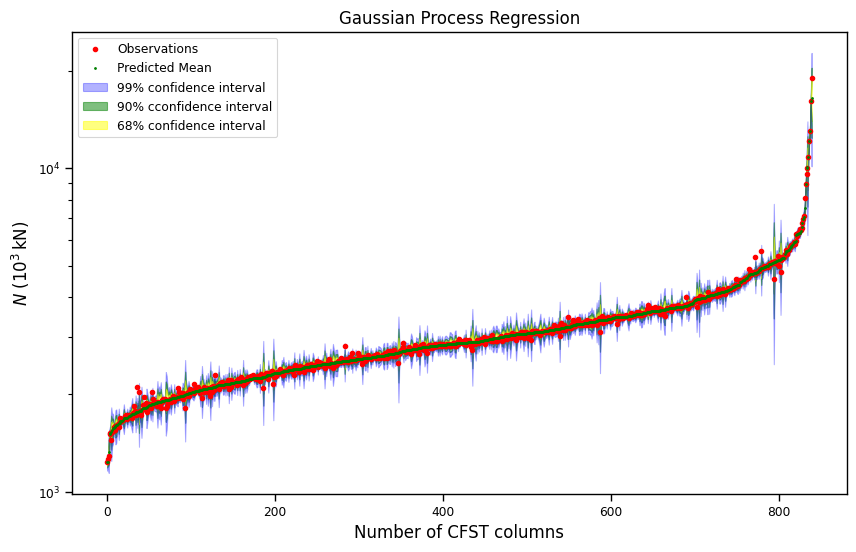

In [83]:

y_tot11=y_tot;X_tot11=X_tot;y_pred11=y_pred;y_std2=y_std
yr=y_std2.reshape(-1, 1)+y_pred.reshape(-1, 1)
data = scaler_out.inverse_transform( y_tot11.reshape(-1, 1))
data1= scaler_out.inverse_transform(y_pred11.reshape(-1, 1))
yr   = scaler_out.inverse_transform(yr.reshape(-1, 1))
y_std2=yr.reshape(-1, 1)-data.reshape(-1, 1)
X     =     scaler.inverse_transform(X_tot)

data2=np.concatenate((X,data.reshape(-1, 1),data1.reshape(-1, 1)),axis=1)
df = pd.DataFrame(data2)
df.columns=['B', 'H', 'Lam', 'frebar', 'fc', 'delta','tw2', 'tf', 'hs2', 'bf2','A_rebar','P_exp','P_pred'];PC=df;PC['sd']=y_std2

f_fc = 0.85
Ar = PC['A_rebar'];tw2=PC['tw2'];tf=PC['tf'];bf2=PC['bf2'];hs2=PC['hs2']
As = ((hs2 * 2.) * (bf2 * 2.) - (hs2 * 2. - 2. * tf) * (bf2 * 2. - 2. * tw2))
Ac = H * B - Ar - As

pc = Ac * fc * f_fc
PC['multi'] = (pc + Ar * frebar)/(1.0-PC['delta'])
PC['P_exp']=PC['P_exp']*PC['multi'];PC['P_pred']=PC['P_pred']*PC['multi'];PC['sd']=PC['sd']*PC['multi']
y_tot11=np.array(PC['P_exp'].values);y_pred11=np.array(PC['P_pred'].values);y_std2=np.array(PC['sd'].values)

#arrange
vv = np.vstack((X_tot11.transpose(),y_std2,y_tot11,y_pred11)).transpose()
v1 = vv[np.argsort(vv[:, -1])]
#previous sheet excel is wrong as you didnot sort x_tot
X_tot11,y_std2,y_tot11,y_pred11=v1[:,:-3],v1[:,-3],v1[:,-2],v1[:,-1]
# Calculate the upper and lower confidence bounds
#0.674
#2.576 is 99% confidence 1.96 is 95%confidence interval #1.645 is 90% #2.576 for 99% #1.0 for 68%
lower_bound99 = y_pred11.flatten() - 2.576* y_std2.flatten();upper_bound99 = y_pred11.flatten() + 2.576* y_std2.flatten()#99% confidence
lower_bound90 = y_pred11.flatten() - 1.645* y_std2.flatten();upper_bound90 = y_pred11.flatten() + 1.645* y_std2.flatten()#1.645 is 90%
lower_bound68 = y_pred11.flatten() - 1.0  * y_std2.flatten();upper_bound68 = y_pred11.flatten() + 1.0  * y_std2.flatten()#1.0 for 68%
# Plot the data, true function, and confidence intervals
plt.figure(figsize=(10, 6))
sizy=np.arange(lower_bound68.shape[0])
plt.semilogy(sizy, y_tot11, 'ro', label='Observations', markersize=3);plt.semilogy(sizy, y_pred11, 'go', label='Predicted Mean', markersize=1)
# Fill between the confidence bounds
plt.fill_between(sizy, upper_bound90.flatten(), upper_bound99.flatten(), color='blue', alpha=0.3,label='99% confidence interval')
plt.fill_between(sizy, upper_bound68.flatten(), upper_bound90.flatten(), color='green', alpha=0.5,label='90% cconfidence interval')
plt.fill_between(sizy, lower_bound68.flatten(), upper_bound68.flatten(), color='yellow', alpha=0.5,label='68% confidence interval')
plt.fill_between(sizy, lower_bound90.flatten(), lower_bound68.flatten(), color='green', alpha=0.5)
plt.fill_between(sizy, lower_bound99.flatten(), lower_bound90.flatten(), color='blue', alpha=0.3)

plt.xlabel('Number of CFST columns');plt.ylabel(r'$N$ ($10^3 \, \mathrm{kN}$)');plt.title('Gaussian Process Regression');plt.legend()
plt.savefig("GPR_Predicted_Mean_Confidence_Intervals1i.png", dpi=500)
plt.show()


# Eurcode4

In [1]:
import numpy as np
import scipy.io as sio
import pandas as pd

def EC4RA(X, ntest):
    B = X[0]; H = X[1]; lam = X[2]; frebar = X[3]; fc = X[4]; fy = X[5]
    d_steel = X[6]; ro_rebar = X[7]; tf_tw_2 = X[8]; cH = X[9]; cB = X[10]
    
    Astr = 50
    S_space = 1000 * 50 * 2 / min(B, H)
    fstr = 250.0
    A_rebar_4 = ro_rebar * B * H / 4.0
    cover = 30
    
    L = lam * B
    hs2 = (H - 2.0 * cH) / 2.0
    bf2 = (B - 2.0 * cB) / 2.0
    
    A_steel_4 = (4.*A_rebar_4 * frebar + 0.85 * B * H * 0.97 * fc) * d_steel / fy / 4.0
    tw2 = A_steel_4 / ((bf2 - 4.0) * tf_tw_2 + hs2)
    tf = (A_steel_4 - hs2 * tw2) / (bf2 - tw2)
    
    #frebar1=fy;fy=frebar;frebar=frebar1
    f_fc = 0.85
    Es = 210000
    Ec = 22000 * ((fc + 8.) / 10.)**0.3
    Ar = ro_rebar * B * H
    As = ((hs2 * 2.) * (bf2 * 2.) - (hs2 * 2. - 2. * tf) * (bf2 * 2. - 2. * tw2))
    Ac = H * B - Ar - As
    
    I_S_X = ((hs2 * 2.)**3. * (bf2 * 2.) - (hs2 * 2. - 2. * tf)**3 * (bf2 * 2. - 2. * tw2)) / 12.0
    I_REBAR_X = Ar * (H - 2.0 * cover)**2. / 4.0
    EI1 = (I_S_X + I_REBAR_X) * Es + (H**3. * B/12.0 - I_S_X - I_REBAR_X) * Ec * 0.6
    
    I_S_Y = ((bf2 * 2.)**3. * tf * 2.0 + (hs2 * 2. - 2. * tf) * (2. * tw2)**3) / 12.0
    I_REBAR_Y = Ar * (B - 2.0 * cover)**2. / 4.0
    EI2 = (I_S_Y + I_REBAR_Y) * Es + (H * B**3./12.0 - I_S_Y - I_REBAR_Y) * Ec * 0.6
    EI = min(EI1, EI2)
    #print(EI1/EI2)
    pc = Ac * fc * f_fc
    pa = pc + As * fy + Ar * frebar
    
    Ncr = (np.pi**2. * EI) / (L * L)
    slender = (pa / Ncr)**0.5
    #print(slender)
    phi = 0.5 * (1 + 0.21 * (slender - 0.2) + slender**2)
    chi = min(1, 1 / (phi + (phi**2 - slender**2)**0.5))
    chi = min(1, (phi - (phi**2 - slender**2)**0.5)/slender**2)
    EC4 = chi * pa
    #print(chi)
    ratioECP1 = ntest[0] / EC4*1000
    #print(slender, ratioECP1)
    #print(ntest)
    return ratioECP1, slender, lam,chi,EC4/1000.0

# Load the data from .mat file
mat_data = sio.loadmat('X_Y_data1.mat')
X = mat_data['X_all']  # Assuming X is stored as 'X' in the .mat file
Y = mat_data['Y_all']  # Assuming Y is stored as 'Y' in the .mat file

# Calculate the ratio for each specimen
results = np.array([EC4RA(X[i, :], Y[i]) for i in range(X.shape[0])])

# Separate the results into three arrays
ratios = results[:, 0]
slender = results[:, 1]
lam = results[:, 2]
chi = results[:, 3] 
P1 = results[:, 4] 
# Create a DataFrame to store X, Y, ratios, slender, and lam
df = pd.DataFrame(np.hstack([X, Y.reshape(-1, 1),P1.reshape(-1, 1), slender.reshape(-1, 1), lam.reshape(-1, 1), chi.reshape(-1, 1), ratios.reshape(-1, 1)]), 
                  columns=[f'X{i+1}' for i in range(X.shape[1])] + ['P_exp','P_pred', 'Slender', 'Lam' , 'chi', 'Ratio Ntest/NEC4'])

# Export the DataFrame to an Excel sheet
output_file = 'EC4_CFS.xlsx'
df.to_excel(output_file, index=False)
print("EC4_CFS: mean and CoV", np.mean(ratios),np.std(ratios)/np.mean(ratios))

EC4_CFS: mean and CoV 1.4554637279127725 0.1715992649419482


# Proposed Design

In [18]:
import numpy as np
import scipy.io as sio
import pandas as pd

def Proposed(X, ntest):
    B = X[0]; H = X[1]; lam = X[2]; frebar = X[3]; fc = X[4]; fy = X[5]
    d_steel = X[6]; ro_rebar = X[7]; tf_tw_2 = X[8]; cH = X[9]; cB = X[10]
    
    Astr = 50
    S_space = 1000 * 50 * 2 / min(B, H)
    fstr = 250.0
    A_rebar_4 = ro_rebar * B * H / 4.0
    cover = 30
    
    L = lam * B
    hs2 = (H - 2.0 * cH) / 2.0
    bf2 = (B - 2.0 * cB) / 2.0
    
    A_steel_4 = (4.*A_rebar_4 * frebar + 0.85 * B * H * 0.97 * fc) * d_steel / fy / 4.0
    tw2 = A_steel_4 / ((bf2 - 4.0) * tf_tw_2 + hs2)
    tf = (A_steel_4 - hs2 * tw2) / (bf2 - tw2)
    
    #frebar1=fy;fy=frebar;frebar=frebar1

    Es = 210000
    Ec = 22000 * ((fc + 8.) / 10.)**0.3
    Ar = ro_rebar * B * H
    As = ((hs2 * 2.) * (bf2 * 2.) - (hs2 * 2. - 2. * tf) * (bf2 * 2. - 2. * tw2))
    Ac = H * B - Ar - As
    pa = As * fy + Ar * frebar + Ac * fc
    delta = As * fy/(Ac * fc+ As * fy + Ar * frebar)

    
    I_S_X = ((hs2 * 2.)**3. * (bf2 * 2.) - (hs2 * 2. - 2. * tf)**3 * (bf2 * 2. - 2. * tw2)) / 12.0
    I_REBAR_X = Ar * (H - 2.0 * cover)**2. / 4.0
    EI1 = (I_S_X + I_REBAR_X) * Es + (H**3. * B/12.0 - I_S_X - I_REBAR_X) * Ec * (0.8-0.75*delta)
    
    I_S_Y = ((bf2 * 2.)**3. * tf * 2.0 + (hs2 * 2. - 2. * tf) * (2. * tw2)**3) / 12.0
    I_REBAR_Y = Ar * (B - 2.0 * cover)**2. / 4.0
    EI2 = (I_S_Y + I_REBAR_Y) * Es + (H * B**3./12.0 - I_S_Y - I_REBAR_Y) * Ec * (0.5-0.55*delta)
    EI = min(EI1, EI2)
    #print(EI1/EI2)
    
    
    Ncr = (np.pi**2. * EI) / (L * L)
    slender = (pa / Ncr)**0.5
    #print(slender)
    phi = 0.2*slender + 0.13 + 0.72/slender
    chi = 1.29*min(1.0, phi - (phi**2 - 1.0/slender)**0.5)
    pn = As * fy + Ar * frebar + 0.8 * Ac * fc
    EC4 = chi * pn
    #print(chi)
    ratioECP1 = ntest[0] / EC4*1000
    #print(slender, ratioECP1)
    #print(ntest)
    return ratioECP1, slender, lam,chi,EC4/1000.0

# Load the data from .mat file
mat_data = sio.loadmat('X_Y_data1.mat')
X = mat_data['X_all']  # Assuming X is stored as 'X' in the .mat file
Y = mat_data['Y_all']  # Assuming Y is stored as 'Y' in the .mat file

# Calculate the ratio for each specimen
results = np.array([Proposed(X[i, :], Y[i]) for i in range(X.shape[0])])

# Separate the results into three arrays
ratios = results[:, 0]
slender = results[:, 1]
lam = results[:, 2]
chi = results[:, 3] 
P1 = results[:, 4] 
# Create a DataFrame to store X, Y, ratios, slender, and lam
df = pd.DataFrame(np.hstack([X, Y.reshape(-1, 1),P1.reshape(-1, 1), slender.reshape(-1, 1), lam.reshape(-1, 1), chi.reshape(-1, 1), ratios.reshape(-1, 1)]), 
                  columns=[f'X{i+1}' for i in range(X.shape[1])] + ['P_exp','P_pred', 'Slender', 'Lam' , 'chi', 'Ratio Ntest/NEC4'])

# Export the DataFrame to an Excel sheet
output_file = 'prop_CFS.xlsx'
df.to_excel(output_file, index=False)
print("EC4_CFS: mean and CoV", np.mean(ratios),np.std(ratios)/np.mean(ratios))

EC4_CFS: mean and CoV 1.0013287231773131 0.068052632910951


# AISC360

In [54]:
import numpy as np
import scipy.io as sio
import pandas as pd

def AISCRA(X, ntest):
    B = X[0]; H = X[1]; lam = X[2]; frebar = X[3]; fc = X[4]; fy = X[5]
    d_steel = X[6]; ro_rebar = X[7]; tf_tw_2 = X[8]; cH = X[9]; cB = X[10]
    
    Astr = 50
    S_space = 1000 * 50 * 2 / min(B, H)
    fstr = 250.0
    A_rebar_4 = ro_rebar * B * H / 4.0
    cover = 30
    
    L = lam * B
    hs2 = (H - 2.0 * cH) / 2.0
    bf2 = (B - 2.0 * cB) / 2.0
    
    A_steel_4 = (4.*A_rebar_4 * frebar + 0.85 * B * H * 0.97 * fc) * d_steel / fy / 4.0
    tw2 = A_steel_4 / ((bf2 - 4.0) * tf_tw_2 + hs2)
    tf = (A_steel_4 - hs2 * tw2) / (bf2 - tw2)
    
    #frebar1=fy;fy=frebar;frebar=frebar1
    f_fc = 1.0
    #f_fc = 0.85
    Es = 210000
    Ec = 22000 * ((fc + 8.) / 10.)**0.3
    Ar = ro_rebar * B * H
    As = ((hs2 * 2.) * (bf2 * 2.) - (hs2 * 2. - 2. * tf) * (bf2 * 2. - 2. * tw2))
    Ac = H * B - Ar - As
    
    C1=min(0.3,0.1+2.*As/(Ac+As))
    I_S_X = ((hs2 * 2.)**3. * (bf2 * 2.) - (hs2 * 2. - 2. * tf)**3 * (bf2 * 2. - 2. * tw2)) / 12.0
    I_REBAR_X = Ar * (H - 2.0 * cover)**2. / 4.0
    EI1 = (I_S_X + I_REBAR_X) * Es + (H**3. * B/12.0 - I_S_X - I_REBAR_X) * Ec * C1
    I_S_Y = ((bf2 * 2.)**3. * tf * 2.0 + (hs2 * 2. - 2. * tf) * (2. * tw2)**3) / 12.0
    I_REBAR_Y = Ar * (B - 2.0 * cover)**2. / 4.0
    EI2 = (I_S_Y + I_REBAR_Y) * Es + (H * B**3./12.0 - I_S_Y - I_REBAR_Y) * Ec * C1
    EI = min(EI1, EI2)
    EI = EI2
    #print(EI1/EI2)
    pc = Ac * fc * f_fc
    pa = pc + As * fy + Ar * frebar
    
    Ncr = (np.pi**2. * EI) / (L * L)
    if pa / Ncr<2.25:
        AISC=0.658**(pa / Ncr)*pa
    else:
        AISC=0.877*Ncr
    ratioAISC1 = ntest[0] / AISC*1000
    slender=(pa / Ncr)**0.5;chi=AISC/pa
    return ratioAISC1*0.877*0.85, slender, lam,chi,AISC/1000.

# Load the data from .mat file
mat_data = sio.loadmat('X_Y_data1.mat')
X = mat_data['X_all']  # Assuming X is stored as 'X' in the .mat file
Y = mat_data['Y_all']  # Assuming Y is stored as 'Y' in the .mat file

# Calculate the ratio for each specimen
results = np.array([AISCRA(X[i, :], Y[i]) for i in range(X.shape[0])])

# Separate the results into three arrays
ratios = results[:, 0]
slender = results[:, 1]
lam = results[:, 2]
chi = results[:, 3] 
P1 = results[:, 4] 
# Create a DataFrame to store X, Y, ratios, slender, and lam
df = pd.DataFrame(np.hstack([X, Y.reshape(-1, 1),P1.reshape(-1, 1), slender.reshape(-1, 1), lam.reshape(-1, 1), chi.reshape(-1, 1), ratios.reshape(-1, 1)]), 
                  columns=[f'X{i+1}' for i in range(X.shape[1])] + ['P_exp','P_pred', 'Slender', 'Lam' , 'chi', 'Ratio Ntest/NEC4'])

# Export the DataFrame to an Excel sheet
output_file = 'AISC_CFS.xlsx'
df.to_excel(output_file, index=False)
print("AISC_CFS: mean and CoV", np.mean(ratios),np.std(ratios)/np.mean(ratios))

AISC_CFS: mean and CoV 1.6231533601269597 0.1844736643514779
